In [1]:
!ls

sample_data


#External Databases

In [2]:
#! pip install git+https://github.com/huggingface/transformers.git
!pip install transformers==4.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 22.3 MB/s eta 0:00:00


In [3]:
! pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 13.1 MB/s eta 0:00:00


In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [5]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=10df378480a4196fb660e7042dc99920fd779eed4a2550c0d17e7dc47e54b363
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


#Libraries

In [6]:
from google.colab import files

import os
import re
import json
import string

import torch
import torch.nn as nn

import numpy as np
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from datasets import load_dataset
#from collections import Counter
#from conlleval import evaluate

import tensorflow_hub as hub
from keras import backend as K
import torch.nn.functional as F

import transformers
print(transformers.__version__)
from transformers import TrainingArguments
from transformers import Trainer

from transformers import Trainer
from transformers.trainer_utils import EvalLoopOutput

from seqeval.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs
from datasets import load_metric
from sklearn.metrics import f1_score, precision_score, recall_score

from transformers import AutoTokenizer, AutoModel
BertTokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
BertEmbModel = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

4.20.0


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#Loading Dataset NCBI

In [7]:
class NCBIDataset(torch.utils.data.Dataset):
  def __init__(self, raw_dataset, max_length=250):
    self.raw_x = [x['tokens'] for x in raw_dataset]
    self.raw_y = [x['ner_tags'] for x in raw_dataset]

    self.max_length = max_length

  def tokenize_and_preserve_labels(self, sentence, text_labels):
    """
    The tokenizer can split single words into multiple tokens - this breaks
    the labels, so we need to keep track of this!
    """
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = BertTokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

  def __getitem__(self, idx):
    tokens = self.raw_x[idx]
    labels = np.zeros((len(tokens)))
    for i, label in enumerate(self.raw_y[idx]):
      if label == 2:
        labels[i] = 1
      else:
        labels[i] = label

    # This could be moved to __init__ to save time?
    tokens, labels = self.tokenize_and_preserve_labels(tokens, labels)

    # Convert each token to an id number
    input_ids = BertTokenizer.convert_tokens_to_ids(tokens)

    # add and adjust for special tokens
    input_ids = [BertTokenizer.cls_token_id] + input_ids + [BertTokenizer.sep_token_id]
    labels = [0] + labels + [0]

    # Pad inputs
    input_ids = torch.tensor(np.pad(input_ids, [0, self.max_length-len(input_ids)]))
    labels = torch.tensor(np.pad(labels, [0, self.max_length-len(labels)], constant_values=-100))

    for x in range(len(labels)):
      if labels[x] == 1:
        labels[x] = 5

    attention_mask = torch.tensor([int(i != 0) for i in input_ids])

    #return {input_ids, labels}
    #return {'input_ids': [input_ids], 'labels': labels}
    return {'input_ids': [input_ids], 'attention_mask': [attention_mask], 'labels': labels}

  def __len__(self):
    return len(self.raw_y)

In [8]:
# Entity mapping, uses BIO tags
def Entity2ID(Sc_Entity):
  return {
        'B': 5,
        'I': 5,
        'O': 0,
    }[Sc_Entity]

def ID2Entity(Sc_Entity):
  return {
        5: 'I-OtherScientificTerm',
        #5: 'I',
        0: 'None',
    }[Sc_Entity]


In [9]:
# Download dataset using datasets, might need to install it!
from datasets import load_dataset

raw_train = load_dataset('ncbi_disease', split='train')
raw_test = load_dataset('ncbi_disease', split='test')
raw_val = load_dataset('ncbi_disease', split='validation')

# Convert to torch datasets
train_NCBI = NCBIDataset(raw_train)
test_NCBI = NCBIDataset(raw_test)
val_NCBI = NCBIDataset(raw_val)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5433 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/924 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

In [10]:
len(train_NCBI), len(test_NCBI), len(val_NCBI)

(5433, 941, 924)

In [11]:
train_NCBI[2739]

{'input_ids': [tensor([  102,   407,   453,  3768,   198,   158,   546,  1211,   259,  1168,
           4662,   115, 30132,  7411,   165,  3111,   214,   106,  2317,   579,
           2971,  2147,  6110,  7459,   198,  4080, 24241,  5354,   131, 10906,
            370,   781,  2980, 13718,   422,  2429,   121,  3014,   131,   106,
          12462, 11458, 13348,   422,   170,   546,   111,  2317,   579,  2971,
           2147,  7459,   121,   111,  1211,   259,   115, 30132, 30147, 30131,
            983,   165,  3974,  1111,   190,   111,  9995, 16147,  1352,  5255,
           2665,   106,  1678,   422,   132,  1828,   422,   115, 30132, 30147,
          30131,   422, 11412, 30113,   422,   115, 30140, 30110, 30140,   422,
            115, 30140, 30125, 30132,   422,   741, 30128, 30132,   422,  3849,
            198,   355,   115, 30132,   579, 13869,  2374,   190,   238, 16147,
           1352,  5255,  2665,   650, 14480,   111,  2317,   579,  2971,  2147,
            115, 30132,   9

In [12]:
val_NCBI[73]

{'input_ids': [tensor([ 102, 2074, 7342,  137, 4406,  131, 1168, 6625, 5722, 6224,  214,  106,
          2576, 8047, 1017, 1168, 6183,  566,  489,  114,  579,  735, 1199,  205,
           103,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
   

In [13]:
local_hp_train_NCBI = []
local_hp_val_NCBI = []
for x in range(500):
  local_hp_train_NCBI.append(train_NCBI[x])

for x in range(180):
  local_hp_val_NCBI.append(val_NCBI[x])

print(len(local_hp_train_NCBI))
print(local_hp_train_NCBI[1])

500
{'input_ids': [tensor([  102,   111, 24243,   861,   153,  7503,  1070,  5703,   145, 16036,
          546,  7421,   579, 14957,   787,  3151,   111, 12157, 10636,  3430,
          214,  8437,   106,  1127,   190, 18260, 12242,  4655,   239, 12186,
          145, 20362,   579,   239, 12186,   546,   422, 10361, 30111,  1352,
         6030,   107,   137,  6130, 14025,   205,   103,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

#Loading Dataset SciTDM

In [14]:
uploaded = files.upload()

Saving test_500_v2.conll to test_500_v2.conll
Saving train_1500_v2.conll to train_1500_v2.conll


In [15]:
class TDMSciDataset(torch.utils.data.Dataset):
  def __init__(self, raw_x, raw_y, max_length=250):
    self.raw_x = raw_x
    self.raw_y = raw_y

    self.max_length = max_length

  def tokenize_and_preserve_labels(self, sentence, text_labels):
    """
    The tokenizer can split single words into multiple tokens - this breaks
    the labels, so we need to keep track of this!
    """
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = BertTokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

  def __getitem__(self, idx):
    tokens = self.raw_x[idx]
    labels = np.zeros((len(tokens)))
    for i, label in enumerate(self.raw_y[idx]):
      labels[i] = label

    # This could be moved to __init__ to save time?
    tokens, labels = self.tokenize_and_preserve_labels(tokens, labels)

    # Convert each token to an id number
    input_ids = BertTokenizer.convert_tokens_to_ids(tokens)

    # add and adjust for special tokens
    input_ids = [BertTokenizer.cls_token_id] + input_ids + [BertTokenizer.sep_token_id]
    labels = [0] + labels + [0]

    # Pad inputs
    input_ids = torch.tensor(np.pad(input_ids, [0, self.max_length-len(input_ids)]))
    labels = torch.tensor(np.pad(labels, [0, self.max_length-len(labels)], constant_values=-100))

    attention_mask = torch.tensor([int(i != 0) for i in input_ids])

    #return {input_ids, labels}
    #return {'input_ids': [input_ids], 'labels': labels}
    return {'input_ids': [input_ids], 'attention_mask': [attention_mask], 'labels': labels}

  def __len__(self):
    return len(self.raw_y)


In [16]:
# Entity maps
def Entity2ID(Sc_Entity):
  return {
        'TASK': 1,
        'DATASET': 4,
        'METRIC': 3,
        'None': 0,
        'O': 0,
    }[Sc_Entity]

def ID2Entity(Sc_Entity):
  return {
        1: 'TASK',
        4: 'DATASET',
        3: 'METRIC',
        0: 'None',
    }[Sc_Entity]

In [17]:
# Load raw data train
raw_x = []
raw_y = []

cur_x = []
cur_y = []
with open('train_1500_v2.conll', 'r') as f:
  for line in f:
    if len(line.strip()) <= 3:
      raw_x.append(cur_x)
      raw_y.append(cur_y)
      cur_x = []
      cur_y = []
    else:
      line = line.strip().split('\t')
      cur_x.append(line[0])
      cur_y.append(Entity2ID(line[-1].split('-')[-1]))

print(raw_x[10])
print(raw_y[10])

# Create actual dataset
train_SciTDM = TDMSciDataset(raw_x, raw_y)

#print(train[0])

['The', 'results', 'show', 'that', 'proposed', 'shallow', 'representations', 'of', 'sentence', 'structure', 'are', 'robust', 'to', 'reductions', 'in', 'parsing', 'accuracy', ',', 'and', 'that', 'the', 'contribution', 'of', 'alternative', 'representations', 'of', 'sentence', 'structure', 'to', 'successful', 'semantic', 'role', 'labeling', 'varies', 'with', 'the', 'integrity', 'of', 'the', 'parsing', 'and', 'argument', '-', 'identification', 'stages', '.', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]


In [18]:
# Load raw data test
raw_x = []
raw_y = []

cur_x = []
cur_y = []
with open('test_500_v2.conll', 'r') as f:
  for line in f:
    if len(line.strip()) <= 3:
      raw_x.append(cur_x)
      raw_y.append(cur_y)
      cur_x = []
      cur_y = []
    else:
      line = line.strip().split('\t')
      cur_x.append(line[0])
      cur_y.append(Entity2ID(line[-1].split('-')[-1]))

print(raw_x[10])
print(raw_y[10])

# Create actual dataset
test_SciTDM = TDMSciDataset(raw_x, raw_y)

#print(test[0])

['We', 'evaluate', 'our', 'approach', 'on', 'three', 'datasets', ':', 'TriviaQA', 'unfiltered', '(', ',', 'a', 'dataset', 'of', 'questions', 'from', 'trivia', 'databases', 'paired', 'with', 'documents', 'found', 'by', 'completing', 'a', 'web', 'search', 'of', 'the', 'questions', ';', 'TriviaQA', 'web', ',', 'a', 'dataset', 'derived', 'from', 'TriviaQA', 'unfiltered', 'by', 'treating', 'each', 'question', 'document', 'pair', 'where', 'the', 'document', 'contains', 'the', 'question', 'answer', 'as', 'an', 'individual', 'training', 'point', ';', 'and', 'SQuAD', '(', ',', 'a', 'collection', 'of', 'Wikipedia', 'articles', 'and', 'crowdsourced', 'questions', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
len(test_SciTDM), len(train_SciTDM)

(486, 1522)

In [20]:
#train[1]

In [21]:
local_hp_train_SciTDM = []
local_hp_val_SciTDM = []
for x in range(500):
  local_hp_train_SciTDM.append(train_SciTDM[x])

for x in range(180):
  local_hp_val_SciTDM.append(test_SciTDM[x])

#print(len(local_hp_train))
#print(local_hp_train[1])

#Loading Dataset SciERC

In [22]:
uploaded = files.upload()

Saving dev.json to dev.json
Saving test.json to test.json
Saving train.json to train.json


In [23]:
class SciERCDataset(torch.utils.data.Dataset):
  def __init__(self, raw_data, entity_map, max_length=250):
    # Need to fix sentence offset for labels!!
    for i, sample in enumerate(raw_data):
      sent_offset = 0
      for j, sent in enumerate(sample['sentences']):
        for k, ner in enumerate(sample['ner'][j]):
          raw_data[i]['ner'][j][k] = [raw_data[i]['ner'][j][k][0] - sent_offset,
                                      raw_data[i]['ner'][j][k][1] - sent_offset,
                                      raw_data[i]['ner'][j][k][2]]
        sent_offset += len(sent)

    sentences = [x['sentences'] for x in raw_data]
    self.raw_x = [sent for sublist in sentences for sent in sublist]

    ners = [x['ner'] for x in raw_data]
    self.raw_y = [ner for sublist in ners for ner in sublist]

    self.entity_map = entity_map
    self.max_length = max_length

  def tokenize_and_preserve_labels(self, sentence, text_labels):
    """
    The tokenizer can split single words into multiple tokens - this breaks
    the labels, so we need to keep track of this!
    """
    tokenized_sentence = []
    labels = []
    prev_label = 0

    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = BertTokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        if label != 0:
          labels.extend([-100] * n_subwords)
          labels[-1 * n_subwords] = label
        else:
          labels.extend([label] * n_subwords)

        prev_label = label

    return tokenized_sentence, labels

  def __getitem__(self, idx):
    tokens = self.raw_x[idx]
    labels = np.zeros((len(tokens)))

    #For Span
    for ner in self.raw_y[idx]:  # Returns [start_idx, end_idx, string label]
      assert len(tokens) >= ner[0], '{}, {}'.format(tokens, ner)
      ner_name = 'I-' + ner[-1]
      label = self.entity_map(ner_name)  # Get the integer label
      labels[ner[0]:ner[1]+1] = label
      #labels[ner[0]] = label - 1

    #For BIO
    #for ner in self.raw_y[idx]:  # Returns [start_idx, end_idx, string label]
    #  assert len(tokens) >= ner[0], '{}, {}'.format(tokens, ner)  # Double checking the labels are correct
    #  ner_name = 'I-' + ner[-1]  # assume all are "I" labels
    #  label = self.entity_map(ner_name)  # Get the integer label
    #  labels[ner[0]:ner[1]+1] = label
    #  labels[ner[0]] = label - 1  # Change first one to "B" label

    # This could be moved to __init__ to save time?
    tokens, labels = self.tokenize_and_preserve_labels(tokens, labels)

    # Convert each token to an id number
    input_ids = BertTokenizer.convert_tokens_to_ids(tokens)

    # add and adjust for special tokens
    input_ids = [BertTokenizer.cls_token_id] + input_ids + [BertTokenizer.sep_token_id]
    labels = [0] + labels + [0]

    # Pad inputs
    input_ids = torch.tensor(np.pad(input_ids, [0, self.max_length-len(input_ids)]))
    labels = torch.tensor(np.pad(labels, [0, self.max_length-len(labels)], constant_values=-100))

    attention_mask = torch.tensor([int(i != 0) for i in input_ids])

    return {'input_ids': [input_ids], 'attention_mask': [attention_mask], 'labels': labels}

  def __len__(self):
    return len(self.raw_y)

In [24]:
def Entity2ID(Sc_Entity):
  return {
        'I-Task': 1,
        'I-Method': 2,
        'I-Metric': 3,
        'I-Material': 4,
        'I-OtherScientificTerm': 5,
        'I-Generic': 6,
        'None': 0
    }[Sc_Entity]

def ID2Entity(Sc_Entity):
  return {
        1: 'I-Task',
        2: 'I-Method',
        3: 'I-Metric',
        4: 'I-Material',
        5: 'I-OtherScientificTerm',
        6: 'I-Generic',
        0: 'O'
    }[Sc_Entity]

In [25]:
train_data = []
with open('train.json','r') as f:
  for line in f:
    train_data.append(json.loads(line))

test_data = []
with open('test.json','r') as f:
  for line in f:
    test_data.append(json.loads(line))

val_data = []
with open('dev.json','r') as f:
  for line in f:
    val_data.append(json.loads(line))

#train_data[3]['sentences'][0], train_data[3]['ner'][0], len(train_data[3]['sentences'][1])
len(train_data), len(test_data), len(val_data)

(350, 100, 50)

In [26]:
train_SciERC = SciERCDataset(train_data, Entity2ID)
val_SciERC = SciERCDataset(val_data, Entity2ID)
test_SciERC = SciERCDataset(test_data, Entity2ID)

In [27]:
len(train_SciERC), len(test_SciERC), len(val_SciERC)

(1861, 551, 275)

In [28]:
#tokens = BertTokenizer.convert_ids_to_tokens(train[1]['input_ids'][0])
#labels = train[1]['labels']
#print(' '.join(tokens))
#print(labels)

In [29]:
train_SciERC[0]

{'input_ids': [tensor([  102,  6170,   165,   817,   147,   195,   428,   579,  2220,   579,
           2159,   191,   111,  2525,   131,  7395, 30113,   131,   111,  1222,
           1211,   198,  3862,  8503, 13510,  2057,   579,  8595,  4111,   205,
            103,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

#Unifiying Loaded Datasets

In [30]:
len(train_NCBI), len(train_SciTDM), len(train_SciERC)

(5433, 1522, 1861)

In [31]:
len(test_NCBI), len(test_SciTDM), len(test_SciERC)

(941, 486, 551)

In [32]:
len(val_NCBI), len(val_SciERC)

(924, 275)

In [33]:
len(local_hp_train_NCBI), len(local_hp_train_SciTDM), len(local_hp_val_NCBI), len(local_hp_val_SciTDM)

(500, 500, 180, 180)

In [34]:
train = train_NCBI + train_SciTDM + train_SciERC
test = test_NCBI + test_SciTDM + test_SciERC
val = val_NCBI + val_SciERC + local_hp_val_SciTDM
local_hp_train = local_hp_train_NCBI + local_hp_train_SciTDM
local_hp_val = local_hp_val_NCBI + local_hp_val_SciTDM
print(len(train), len(test), len(val), len(local_hp_train), len(local_hp_val))
print(train[2000])

8816 1978 1379 1000 360
{'input_ids': [tensor([  102,   106,   983,   422, 15162, 30118, 30130,   422,  6525,   121,
          106,  1454,   190,  5390, 30113,  5855,   422,   434,   528,  1887,
          137,   797,   147, 12886,   106,   787,   190, 11600,   147, 16745,
         1352, 10837, 29730,  7948,  4446,  1391,   145, 16745,  1352, 10837,
        15325,   546,   205,   103,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

# Pytorch Model Definition

In [35]:
class NerModel(nn.Module):
  def __init__(self, b_embeddings, emb_dims=768, ff_dims=14, out_dims=7):
    super(NerModel, self).__init__()
    self.sci_embeddings = b_embeddings
    self.embd_dropout = nn.Dropout(0.1)
    self.ff_dropout = nn.Dropout(0.1)
    self.ff = nn.Linear(emb_dims, ff_dims)
    #self.tanh = nn.Tanh()#
    #self.lstm = nn.LSTM(emb_dims, 100, 1, bidirectional=True)#
    #self.lstm_drop = nn.Dropout(0.4)#
    self.ff = nn.Linear(768, ff_dims)#
    self.ff_act = nn.ReLU()
    self.classifier = nn.Linear(ff_dims, out_dims)
  def forward(self, input_ids=None, attention_mask=None, labels=None):
    embds = self.sci_embeddings(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']
    out = self.embd_dropout(embds)
    #out, _ = self.lstm(out)#
    #out = self.tanh(out)#
    #out = self.lstm_drop(out)#
    out = self.ff(out)
    out = self.ff_act(out)
    out = self.ff_dropout(out)
    out = self.classifier(out)
    return out


# Metrics and Configs

In [36]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

import math

def load_param():
  for n, v in best_run.hyperparameters.items():
    if n == 'seed':
      setattr(trainer.args, n, math.ceil(v))
      print(n, math.ceil(v))
    else:
      setattr(trainer.args, n, v)
      print(n, v)

In [37]:
batch_size = 4
training_args = TrainingArguments(
    "trained_scibert_ner_model", # output dir
    learning_rate=1e-5,
    num_train_epochs=10,
    dataloader_drop_last=True,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    logging_steps=50,
    save_steps=len(train) // batch_size,
    lr_scheduler_type='cosine',
    evaluation_strategy='steps',
    eval_steps=len(train) // batch_size)
#print(training_args)

In [38]:
def collator(batch):
  out =  {
      'input_ids': torch.stack([(x['input_ids'][0]) for x in batch]),
      'attention_mask': torch.stack([x['attention_mask'][0] for x in batch]),
      'labels': torch.stack([x['labels'].clone().detach() for x in batch])
  }
  return out

In [39]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight, gamma, reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, ignore_index=-100, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [40]:
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_labels=7):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs

        #weights = torch.tensor([0.1, 1.5, 1.55, 1.9, 1.75, 1.65, 1.9]).cuda()  # The no-class label has too many examples, we need to weight the loss - this probably needs further tuning

        #weights = torch.tensor([0.1, 1.5, 1.2, 1.9, 1.75, 1.3, 1.85]).cuda()

        #weights = torch.tensor([0.89, 1.73, 1.69, 1.79, 1.76, 1.7, 1.77]).cuda()

        #weights = torch.tensor([0.89, 1.69, 1.65, 1.84, 1.75, 1.66, 1.77]).cuda()

        #weights = torch.tensor([0.95, 1.6, 1.5, 1.94, 1.7, 1.55, 1.83]).cuda()

        #weights = torch.tensor([0.12, 0.83, 0.78, 1.0, 0.88, 0.8, 0.95]).cuda()

        #weights = torch.tensor([0.42, 1.5, 1.2, 2.0, 1.6, 1.4, 1.8]).cuda()

        #weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda()

        #weights = torch.tensor([0.1, 1.36, 0.93, 7.45, 2.66, 1.01, 3.51]).cuda()

        weights = torch.tensor([0.26, 0.95, 0.92, 0.99, 0.97, 0.93, 0.98]).cuda()

        gamma=5
        loss_fct = FocalLoss(weight=weights, gamma=gamma)
        loss = loss_fct(logits.view(-1, num_labels), labels.long().view(-1))
        return (loss, outputs) if return_outputs else loss

    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval", num_labels=7):
      args = self.args
      prediction_loss_only = prediction_loss_only if prediction_loss_only is not None else args.prediction_loss_only

      self.model.eval()

      all_losses = []
      all_preds = []
      all_labels = []
      for step, sample in enumerate(dataloader):
        for i in range(0, len(sample['labels'])):
          inputs = {}
          inputs['input_ids'] = torch.stack([sample['input_ids'][i].cuda()])
          inputs['attention_mask'] = torch.stack([sample['attention_mask'][i].cuda()])
          inputs['labels'] = torch.stack([sample['labels'][i].cuda()])
          labels = inputs['labels'][0].cpu().numpy()

          (loss, logits) = self.compute_loss(self.model, inputs, return_outputs=True)
          logits = logits[0].cpu().detach().numpy()
          preds = np.argmax(nn.Softmax(dim=-1)(torch.tensor(logits)).numpy(), axis=-1)

          all_losses = np.concatenate((all_losses, [loss.detach().cpu().numpy()]), axis=0)

          preds = preds[labels != -100]
          labels = labels[labels != -100]
          all_preds = np.concatenate((all_preds, preds))
          all_labels = np.concatenate((all_labels, labels))

      metrics = {}
      metrics['macro_f1'] = f1_score(all_labels, all_preds, average='macro')
      metrics['macro_precision'] = precision_score(all_labels, all_preds, average='macro', zero_division=0)
      metrics['macro_recall'] = recall_score(all_labels, all_preds, average='macro', zero_division=0)
      metrics['micro_f1'] = f1_score(all_labels, all_preds, average='micro')
      metrics['micro_precision'] = precision_score(all_labels, all_preds, average='micro', zero_division=0)
      metrics['micro_recall'] = recall_score(all_labels, all_preds, average='micro', zero_division=0)

      metrics['macro_f1_no_o'] = f1_score(all_labels, all_preds, average='macro', labels=[1, 2, 3, 4, 5, 6])
      metrics['macro_precision_no_o'] = precision_score(all_labels, all_preds, average='macro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)
      metrics['macro_recall_no_o'] = recall_score(all_labels, all_preds, average='macro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)
      metrics['micro_f1_no_o'] = f1_score(all_labels, all_preds, average='micro', labels=[1, 2, 3, 4, 5, 6])
      metrics['micro_precision_no_o'] = precision_score(all_labels, all_preds, average='micro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)
      metrics['micro_recall_no_o'] = recall_score(all_labels, all_preds, average='micro', labels=[1, 2, 3, 4, 5, 6], zero_division=0)

      for key in list(metrics.keys()):
        if not key.startswith(metric_key_prefix):
          metrics[metric_key_prefix + '_' + key] = metrics.pop(key)

      metrics[metric_key_prefix + '_loss'] = all_losses.mean().item()

      return EvalLoopOutput(predictions=all_preds, label_ids=all_labels, metrics=metrics, num_samples=len(dataloader))

In [41]:
def my_hp_space_ray(trial):
    from ray import tune

    return {
        "learning_rate": tune.loguniform(9e-6, 1e-4),
        "num_train_epochs": tune.choice(range(5, 25)),
        "weight_decay": tune.uniform(0.0, 0.2),
        "per_device_train_batch_size": tune.choice([4, 8, 16]),  #<16 definetly not working
    }

# Hyperparameter Tuning

In [ ]:
def model_init():
    x = NerModel(BertEmbModel)
    x.sci_embeddings.requires_grad = False
    return x

trainer = MultilabelTrainer(model_init=model_init,
                            args=training_args,
                            train_dataset=train,
                            eval_dataset=val,
                            data_collator=collator  # defines how to merge data into batches, using the collator function above
                            )

In [ ]:
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

best_run = trainer.hyperparameter_search(backend="ray",
                                         resources_per_trial={"gpu": 1, "cpu": 0},
                                         n_trials=18,
                                         direction="maximize",
                                         hp_space=my_hp_space_ray,
                                         search_alg=HyperOptSearch(metric='eval_micro_recall_no_o', mode="max"),  #'eval_*f1_micro'
                                         scheduler=ASHAScheduler(metric='eval_micro_recall_no_o', mode="max")
                                         )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_run

BestRun(run_id='b76f4924', objective=10.041451424749862, hyperparameters={'learning_rate': 2.2739809316420813e-05, 'num_train_epochs': 10, 'weight_decay': 0.1000138946264801, 'per_device_train_batch_size': 8})

# Cossvalidation

In [42]:
#import tensorflow as tf
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
from torch import nn
from transformers import Trainer

#print('GPU detected:', tf.config.list_physical_devices('GPU'))
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
results = np.zeros(5)
resultss = np.zeros(5)
dataset = ConcatDataset([train, test])



In [43]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    #train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    #test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    local_train = []
    #i = 0
    for idx in train_ids:
      #if i <= 1920:
        local_train.append(dataset[idx])
      #i += 1

    local_test = []
    #i = 0
    for idx in test_ids:
      #if i <= 480:
        local_test.append(dataset[idx])
      #i += 1

    training_args = TrainingArguments("trained_scibert_ner_model", # output dir
                                      learning_rate=2.2739809316420813e-05,
                                      weight_decay=0.1000138946264801,
                                      num_train_epochs=10,
                                      per_device_eval_batch_size=8,
                                      per_device_train_batch_size=8,
                                      logging_steps=50,
                                      save_steps=len(train) // batch_size,
                                      lr_scheduler_type='cosine',
                                      evaluation_strategy='steps',
                                      dataloader_drop_last=True,
                                      eval_steps=len(train) // batch_size
                                      )

    #learning_rate 2.5923213776958604e-05
    #num_train_epochs 20
    #weight_decay 0.028135787671833536
    #per_device_train_batch_size 16

    # Init the neural network
    ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training

    trainer = MultilabelTrainer(model=ner_model,
                                args=training_args,
                                train_dataset=local_train,
                                eval_dataset=local_test,
                                data_collator=collator  # defines how to merge data into batches, using the collator function above
                                )

    ##Loading Best parameters
    #load_param()

    #Training
    trainer.train()

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(ner_model.state_dict(), save_path)

    # Evaluationfor this fold
    #correct, total = 0, 0
    with torch.no_grad():
      result = trainer.evaluate(local_test)
      print(result)

      # Print accuracy
      print('Accuracy for fold ', fold, ': ', result['eval_micro_f1_no_o'])
      print('--------------------------------')
      results[fold] = result['eval_micro_f1_no_o']
      resultss[fold] = result['eval_micro_f1']
      del result



FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8635
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10790


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000700,0.026432,0.727074,0.680141,0.792745,0.934927,0.934927,0.934927,0.686927,0.629283,0.766332,0.758058,0.692803,0.836885
4408,0.000200,0.029518,0.744673,0.685466,0.826066,0.938405,0.938405,0.938405,0.707271,0.635085,0.805224,0.775424,0.704704,0.861922
6612,0.000100,0.038984,0.754613,0.702715,0.821204,0.943537,0.943537,0.943537,0.718380,0.655378,0.798451,0.788469,0.729223,0.858193
8816,0.000000,0.042813,0.760357,0.713325,0.818319,0.945466,0.945466,0.945466,0.724901,0.667873,0.794624,0.793279,0.739792,0.855103


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.7609709242853716, 'eval_macro_precision': 0.716573705605861, 'eval_macro_recall': 0.8153654790823984, 'eval_micro_f1': 0.9459824750565689, 'eval_micro_precision': 0.9459824750565689, 'eval_micro_recall': 0.9459824750565689, 'eval_macro_f1_no_o': 0.7255586076918034, 'eval_macro_precision_no_o': 0.6717793215134394, 'eval_macro_recall_no_o': 0.7909541567575409, 'eval_micro_f1_no_o': 0.7936776181718773, 'eval_micro_precision_no_o': 0.7438740333550732, 'eval_micro_recall_no_o': 0.8506285957809504, 'eval_loss': 0.042025715584269964, 'eval_runtime': 39.5004, 'eval_samples_per_second': 6.81, 'eval_steps_per_second': 0.861, 'epoch': 10.0}
Accuracy for fold  0 :  0.7936776181718773
--------------------------------
FOLD 1
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8635
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10790


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000100,0.003342,0.846237,0.783190,0.931327,0.968559,0.968559,0.968559,0.823350,0.747708,0.924659,0.883156,0.824129,0.951291
4408,0.000000,0.002876,0.857043,0.794059,0.940532,0.970085,0.970085,0.970085,0.835830,0.760281,0.935251,0.888945,0.830041,0.956849
6612,0.000000,0.003586,0.853042,0.789152,0.935848,0.969813,0.969813,0.969813,0.831147,0.754591,0.929722,0.886421,0.828924,0.952490
8816,0.000000,0.003332,0.867916,0.813379,0.936409,0.972503,0.972503,0.972503,0.848307,0.782855,0.930003,0.897316,0.843909,0.957938


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.8680835588287046, 'eval_macro_precision': 0.8112852500945754, 'eval_macro_recall': 0.9388376435960113, 'eval_micro_f1': 0.9716716021031002, 'eval_micro_precision': 0.9716716021031002, 'eval_micro_recall': 0.9716716021031002, 'eval_macro_f1_no_o': 0.848591007466769, 'eval_macro_precision_no_o': 0.7803655887215041, 'eval_macro_recall_no_o': 0.9330524234895178, 'eval_micro_f1_no_o': 0.8951432635643162, 'eval_micro_precision_no_o': 0.8384886266298658, 'eval_micro_recall_no_o': 0.9600087174457884, 'eval_loss': 0.003261957019442161, 'eval_runtime': 40.5988, 'eval_samples_per_second': 6.626, 'eval_steps_per_second': 0.837, 'epoch': 10.0}
Accuracy for fold  1 :  0.8951432635643162
--------------------------------
FOLD 2
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8635
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10790


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000000,0.000994,0.883933,0.821141,0.966196,0.975522,0.975522,0.975522,0.866816,0.791567,0.964733,0.909573,0.849291,0.979066
4408,0.000000,0.001084,0.886811,0.823546,0.967232,0.976392,0.976392,0.976392,0.870037,0.794349,0.965696,0.910410,0.853048,0.976044
6612,0.000000,0.001834,0.888282,0.830962,0.963624,0.977727,0.977727,0.977727,0.871617,0.803060,0.961166,0.914367,0.861943,0.973581
8816,0.000000,0.002027,0.899798,0.848166,0.965244,0.979827,0.979827,0.979827,0.884879,0.823134,0.962713,0.922393,0.874423,0.975932


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.8973929746082383, 'eval_macro_precision': 0.8431347417981089, 'eval_macro_recall': 0.9674622416605845, 'eval_micro_f1': 0.9798419150180733, 'eval_micro_precision': 0.9798419150180733, 'eval_micro_recall': 0.9798419150180733, 'eval_macro_f1_no_o': 0.8820701058025024, 'eval_macro_precision_no_o': 0.8172492262801141, 'eval_macro_recall_no_o': 0.9653096895115318, 'eval_micro_f1_no_o': 0.9224261012109354, 'eval_micro_precision_no_o': 0.8741230707556624, 'eval_micro_recall_no_o': 0.9763797156610321, 'eval_loss': 0.0021315262308267626, 'eval_runtime': 39.9221, 'eval_samples_per_second': 6.738, 'eval_steps_per_second': 0.852, 'epoch': 10.0}
Accuracy for fold  2 :  0.9224261012109354
--------------------------------
FOLD 3
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8635
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10790


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000000,0.000615,0.896290,0.844536,0.963712,0.979884,0.979884,0.979884,0.880804,0.818884,0.960976,0.927692,0.881966,0.978420
4408,0.000000,0.000585,0.901166,0.846412,0.971346,0.979869,0.979869,0.979869,0.886524,0.821022,0.969993,0.928825,0.880890,0.982277
6612,0.000000,0.000544,0.916896,0.872584,0.972091,0.984243,0.984243,0.984243,0.904470,0.851600,0.970020,0.943255,0.906948,0.982590
8816,0.000000,0.000577,0.915275,0.868949,0.974165,0.984213,0.984213,0.984213,0.902590,0.847370,0.972450,0.943455,0.907140,0.982798


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9181901324641972, 'eval_macro_precision': 0.873049229823182, 'eval_macro_recall': 0.973746616739769, 'eval_micro_f1': 0.9844821904676313, 'eval_micro_precision': 0.9844821904676313, 'eval_micro_recall': 0.9844821904676313, 'eval_macro_f1_no_o': 0.9059733068916446, 'eval_macro_precision_no_o': 0.852118479070183, 'eval_macro_recall_no_o': 0.9719627384790629, 'eval_micro_f1_no_o': 0.9446889377875576, 'eval_micro_precision_no_o': 0.9078239138792772, 'eval_micro_recall_no_o': 0.984674728940784, 'eval_loss': 0.0005564289396975251, 'eval_runtime': 42.8575, 'eval_samples_per_second': 6.277, 'eval_steps_per_second': 0.793, 'epoch': 10.0}
Accuracy for fold  3 :  0.9446889377875576
--------------------------------
FOLD 4
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8636
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10790


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000500,0.007773,0.788114,0.742577,0.917595,0.942168,0.942168,0.942168,0.757630,0.700016,0.912943,0.792554,0.695264,0.921503
4408,0.000000,0.001841,0.920252,0.880160,0.968442,0.984386,0.984386,0.984386,0.908366,0.860573,0.965593,0.941787,0.908781,0.977280
6612,0.000000,0.001944,0.929579,0.891914,0.974444,0.986017,0.986017,0.986017,0.919113,0.874196,0.972419,0.948244,0.916340,0.982449
8816,0.000000,0.002095,0.930201,0.892861,0.974591,0.986272,0.986272,0.986272,0.919818,0.875286,0.972565,0.949272,0.917512,0.983310


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9318544417459007, 'eval_macro_precision': 0.8951003048333954, 'eval_macro_recall': 0.9754354736686894, 'eval_micro_f1': 0.9866910190577421, 'eval_micro_precision': 0.9866910190577421, 'eval_micro_recall': 0.9866910190577421, 'eval_macro_f1_no_o': 0.9217150742909513, 'eval_macro_precision_no_o': 0.8778954644365603, 'eval_macro_recall_no_o': 0.9734888385637405, 'eval_micro_f1_no_o': 0.9509885535900103, 'eval_micro_precision_no_o': 0.9200644316923386, 'eval_micro_recall_no_o': 0.9840637450199203, 'eval_loss': 0.002088545760403465, 'eval_runtime': 41.2082, 'eval_samples_per_second': 6.528, 'eval_steps_per_second': 0.825, 'epoch': 10.0}
Accuracy for fold  4 :  0.9509885535900103
--------------------------------


# Results

In [44]:
results

array([0.79367762, 0.89514326, 0.9224261 , 0.94468894, 0.95098855])

In [45]:
resultss

array([0.94598248, 0.9716716 , 0.97984192, 0.98448219, 0.98669102])

In [46]:
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
key = 0
for value in results:
  print(f'Fold {key}: {value} %')
  sum += value
  key += 1
print(f'Average: {sum/len(results)} %')

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 0.7936776181718773 %
Fold 1: 0.8951432635643162 %
Fold 2: 0.9224261012109354 %
Fold 3: 0.9446889377875576 %
Fold 4: 0.9509885535900103 %
Average: 0.9013848948649393 %


# Pytorch Training - Loop UPDT

In [47]:
device = 'cuda'

In [48]:
training_args = TrainingArguments("trained_scibert_ner_model", # output dir
                                      learning_rate=2.2739809316420813e-05,
                                      weight_decay=0.1000138946264801,
                                      num_train_epochs=10,
                                      per_device_eval_batch_size=8,
                                      per_device_train_batch_size=8,
                                      logging_steps=50,
                                      dataloader_drop_last=True,
                                      save_steps=len(train) // batch_size,
                                      eval_steps=len(train) // batch_size,
                                      lr_scheduler_type='cosine',
                                      evaluation_strategy='steps',
                                      report_to='all'#,
                                      #warmup_ratio=0.2
                                      )

#learning_rate 2.5923213776958604e-05
#num_train_epochs 20
#weight_decay 0.028135787671833536
#per_device_train_batch_size 16

#load_param()

PyTorch: setting up devices


In [49]:
loop_val = 5
loop_results = np.zeros(loop_val)
loop_resultss = np.zeros(loop_val)
for r in range(loop_val):

  ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training

  ner_model.sci_embeddings.requires_grad = False

  trainer = MultilabelTrainer(
      model=ner_model,
      args=training_args,
      train_dataset=train,
      eval_dataset=test,
      data_collator=collator  # defines how to merge data into batches, using the collator function above
  )

  # Print
  print(f'Train run #{r}')
  print('--------------------------------')

  trainer.train()

  # Process is complete.
  print('Training process has finished.')

  # Print about testing
  print('Starting testing')

  with torch.no_grad():
    result = trainer.evaluate(test)
    print(result)

    # Print accuracy
    print('Accuracy for fold ', r, ': ', result['eval_micro_f1_no_o'], ' -- ', result['eval_micro_f1'])
    print('--------------------------------')
    loop_results[r] = result['eval_micro_f1_no_o']
    loop_resultss[r] = result['eval_micro_f1']
    del result

  if r > 0:
    if loop_results[r] < loop_results[r-1]:
      save_path = f'./model-fold-{r}.pth'
      torch.save(ner_model.state_dict(), save_path)

  print('Testing process has finished.')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8816
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11020


Train run #0
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000000,0.000508,0.908169,0.854279,0.981357,0.977764,0.977764,0.977764,0.894982,0.830201,0.982235,0.928568,0.876612,0.987071
4408,0.000000,0.001562,0.896530,0.842360,0.969924,0.970406,0.970406,0.970406,0.882074,0.816294,0.970204,0.905583,0.839902,0.982408
6612,0.000000,0.000721,0.906376,0.855879,0.970231,0.976114,0.976114,0.976114,0.893022,0.832239,0.969347,0.922394,0.871710,0.979334
8816,0.000000,0.000637,0.917522,0.872085,0.974343,0.980190,0.980190,0.980190,0.905646,0.851177,0.973371,0.935099,0.893893,0.980288
11020,0.000000,0.000593,0.917526,0.871415,0.974279,0.978540,0.978540,0.978540,0.905818,0.850364,0.973656,0.930426,0.884443,0.981454


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-11020
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8816
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11020


{'eval_macro_f1': 0.9175255694662405, 'eval_macro_precision': 0.871415392091581, 'eval_macro_recall': 0.9742790967752663, 'eval_micro_f1': 0.9785400090562132, 'eval_micro_precision': 0.9785400090562132, 'eval_micro_recall': 0.9785400090562132, 'eval_macro_f1_no_o': 0.9058180905726902, 'eval_macro_precision_no_o': 0.8503642600457134, 'eval_macro_recall_no_o': 0.9736564017085486, 'eval_micro_f1_no_o': 0.9304264831466319, 'eval_micro_precision_no_o': 0.8844427466335594, 'eval_micro_recall_no_o': 0.9814540059347181, 'eval_loss': 0.0005925246828083865, 'eval_runtime': 46.3074, 'eval_samples_per_second': 5.334, 'eval_steps_per_second': 0.669, 'epoch': 10.0}
Accuracy for fold  0 :  0.9304264831466319  --  0.9785400090562132
--------------------------------
Testing process has finished.
Train run #1
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000000,0.000570,0.865585,0.840563,0.899274,0.978540,0.978540,0.978540,0.844998,0.814275,0.885804,0.923186,0.880762,0.969903
4408,0.000000,0.000627,0.926181,0.882284,0.980266,0.982567,0.982567,0.982567,0.915529,0.862991,0.979932,0.942843,0.904813,0.984209
6612,0.000000,0.001981,0.901062,0.851751,0.978442,0.979446,0.979446,0.979446,0.886450,0.827431,0.978189,0.930714,0.888964,0.976579
8816,0.000000,0.000836,0.931106,0.891455,0.979063,0.983230,0.983230,0.983230,0.921208,0.873729,0.978359,0.944742,0.909403,0.982938
11020,0.000000,0.000848,0.932143,0.893804,0.978377,0.983731,0.983731,0.983731,0.922374,0.876478,0.977464,0.946434,0.912453,0.983044


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-11020
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8816
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11020


{'eval_macro_f1': 0.9321429454099459, 'eval_macro_precision': 0.893803654777721, 'eval_macro_recall': 0.9783773533409121, 'eval_micro_f1': 0.9837311598421632, 'eval_micro_precision': 0.9837311598421632, 'eval_micro_recall': 0.9837311598421632, 'eval_macro_f1_no_o': 0.9223740660159693, 'eval_macro_precision_no_o': 0.8764784333157664, 'eval_macro_recall_no_o': 0.9774644185923873, 'eval_micro_f1_no_o': 0.9464340373431283, 'eval_micro_precision_no_o': 0.9124532756246311, 'eval_micro_recall_no_o': 0.9830436625688851, 'eval_loss': 0.000847695597717094, 'eval_runtime': 45.7634, 'eval_samples_per_second': 5.397, 'eval_steps_per_second': 0.677, 'epoch': 10.0}
Accuracy for fold  1 :  0.9464340373431283  --  0.9837311598421632
--------------------------------
Testing process has finished.
Train run #2
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000100,0.007378,0.876491,0.834536,0.929366,0.966120,0.966120,0.966120,0.858822,0.808112,0.922234,0.881057,0.834915,0.932599
4408,0.000000,0.001783,0.894540,0.845927,0.956077,0.971974,0.971974,0.971974,0.879421,0.820846,0.953031,0.903255,0.853813,0.958775
6612,0.000000,0.001843,0.907018,0.864927,0.958616,0.976389,0.976389,0.976389,0.893600,0.843072,0.955195,0.917822,0.878268,0.961106
8816,0.000000,0.001640,0.907155,0.863656,0.961650,0.977036,0.977036,0.977036,0.893714,0.841541,0.958691,0.920407,0.880701,0.963862
11020,0.000000,0.001660,0.906463,0.860463,0.964467,0.976535,0.976535,0.976535,0.892957,0.837735,0.962155,0.919170,0.876249,0.966511


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-11020
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.9064632523827478, 'eval_macro_precision': 0.8604633203596969, 'eval_macro_recall': 0.9644674406050627, 'eval_micro_f1': 0.9765347047027622, 'eval_micro_precision': 0.9765347047027622, 'eval_micro_recall': 0.9765347047027622, 'eval_macro_f1_no_o': 0.8929573685627057, 'eval_macro_precision_no_o': 0.8377354536964604, 'eval_macro_recall_no_o': 0.9621553982631584, 'eval_micro_f1_no_o': 0.919169522273735, 'eval_micro_precision_no_o': 0.8762490392006149, 'eval_micro_recall_no_o': 0.9665112335735481, 'eval_loss': 0.0016595606169685594, 'eval_runtime': 47.2002, 'eval_samples_per_second': 5.233, 'eval_steps_per_second': 0.657, 'epoch': 10.0}
Accuracy for fold  2 :  0.919169522273735  --  0.9765347047027622
--------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8816
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11020


Testing process has finished.
Train run #3
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000000,0.003234,0.865692,0.802790,0.951288,0.962401,0.962401,0.962401,0.846659,0.770533,0.949172,0.874739,0.807938,0.953582
4408,0.000000,0.003463,0.884106,0.836553,0.946708,0.970858,0.970858,0.970858,0.867322,0.810233,0.941938,0.898043,0.854667,0.946058
6612,0.000000,0.003488,0.887301,0.838339,0.950287,0.970826,0.970826,0.970826,0.871057,0.812159,0.946279,0.898509,0.851223,0.951357
8816,0.000000,0.003636,0.892870,0.848705,0.949477,0.972330,0.972330,0.972330,0.877451,0.824336,0.945052,0.904112,0.860991,0.951780
11020,0.000000,0.003779,0.894818,0.851726,0.949859,0.972799,0.972799,0.972799,0.879684,0.827882,0.945398,0.905643,0.863947,0.951568


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-11020
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.8948182949728898, 'eval_macro_precision': 0.8517260035397174, 'eval_macro_recall': 0.9498586796826339, 'eval_micro_f1': 0.9727990167539944, 'eval_micro_precision': 0.9727990167539944, 'eval_micro_recall': 0.9727990167539944, 'eval_macro_f1_no_o': 0.8796842564160778, 'eval_macro_precision_no_o': 0.8278819457155032, 'eval_macro_recall_no_o': 0.9453981033956428, 'eval_micro_f1_no_o': 0.9056432497856675, 'eval_micro_precision_no_o': 0.8639468873280093, 'eval_micro_recall_no_o': 0.9515684612123781, 'eval_loss': 0.003779439332593292, 'eval_runtime': 46.9479, 'eval_samples_per_second': 5.261, 'eval_steps_per_second': 0.66, 'epoch': 10.0}
Accuracy for fold  3 :  0.9056432497856675  --  0.9727990167539944
--------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8816
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11020


Testing process has finished.
Train run #4
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
2204,0.000000,0.003066,0.876144,0.829669,0.934682,0.969775,0.969775,0.969775,0.858120,0.802299,0.927985,0.893987,0.851039,0.941501
4408,0.000000,0.004072,0.889210,0.852547,0.934845,0.972977,0.972977,0.972977,0.873089,0.829089,0.927538,0.904343,0.870187,0.941289
6612,0.000000,0.006363,0.887721,0.850978,0.933835,0.972184,0.972184,0.972184,0.871396,0.827299,0.926408,0.900789,0.866686,0.937685
8816,0.000000,0.004221,0.892352,0.852669,0.942227,0.973575,0.973575,0.973575,0.876715,0.829023,0.936276,0.907277,0.868781,0.949343
11020,0.000000,0.004338,0.893577,0.854286,0.942885,0.973850,0.973850,0.973850,0.878127,0.830941,0.936976,0.908298,0.871012,0.948919


Saving model checkpoint to trained_scibert_ner_model/checkpoint-2204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4408
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6612
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8816
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-11020
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




Training process has finished.
Starting testing
{'eval_macro_f1': 0.8935774166669634, 'eval_macro_precision': 0.8542862089181776, 'eval_macro_recall': 0.9428854499298726, 'eval_micro_f1': 0.973850184358626, 'eval_micro_precision': 0.973850184358626, 'eval_micro_recall': 0.973850184358626, 'eval_macro_f1_no_o': 0.8781265431035181, 'eval_macro_precision_no_o': 0.8309413017201326, 'eval_macro_recall_no_o': 0.9369764091421032, 'eval_micro_f1_no_o': 0.9082978291742746, 'eval_micro_precision_no_o': 0.871011673151751, 'eval_micro_recall_no_o': 0.9489190334887664, 'eval_loss': 0.0043378360561473605, 'eval_runtime': 46.2048, 'eval_samples_per_second': 5.346, 'eval_steps_per_second': 0.671, 'epoch': 10.0}
Accuracy for fold  4 :  0.9082978291742746  --  0.973850184358626
--------------------------------
Testing process has finished.


In [50]:
loop_results

array([0.93042648, 0.94643404, 0.91916952, 0.90564325, 0.90829783])

In [51]:
loop_resultss

array([0.97854001, 0.98373116, 0.9765347 , 0.97279902, 0.97385018])

In [52]:
sum = 0.0
for value in loop_results:
  sum += value
print(f'Average micro_f1_no_o: {sum/len(loop_results)} %')

sum = 0.0
for value in loop_resultss:
  sum += value
print(f'Average micro_f1: {sum/len(loop_results)} %')

Average micro_f1_no_o: 0.9219942243446873 %
Average micro_f1: 0.9770910149427519 %


In [53]:
ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training
ner_model.load_state_dict(torch.load(save_path))
ner_model.eval()

NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

# Get Values of Thruth

In [54]:
# Pytorch thing (if we aren't training, do this)
ner_model.eval()
ner_model.to('cuda')

NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [55]:
output_preds = []
output_real = []
for x in range(len(test)):
  inputs1 = test[x]['input_ids'][0].clone().detach().to(torch.long).unsqueeze(0).to('cuda')
  inputs2 = test[x]['attention_mask'][0].clone().detach().to(torch.long).unsqueeze(0).to('cuda')
  inputs = {'input_ids': inputs1,  'attention_mask': inputs2}
  #print(inputs)

  temp_test = test[x]
  temp_out = temp_test.pop("labels")
  output_real.append(np.array(temp_out[temp_out != -100]))

  gen_preds = ner_model(**inputs)
  label_preds = np.argmax(gen_preds.cpu().detach().numpy(), axis=-1)[0]
  output_preds.append(label_preds[temp_out != -100])


In [56]:
for x in range(len(output_real)):
  output_real[x] = [ID2Entity(y) for y in output_real[x]]
  output_preds[x] = [ID2Entity(z) for z in output_preds[x]]

In [57]:
#output_real[28]

[[51213   354    68    54   273   353   125]
 [  111  1940     7     5    19    22     0]
 [   30    27  1098     0     0    13     9]
 [   18     3     0   503     0     1     1]
 [   46    11     0     1  1165     4     2]
 [   56     8    26     1    20  4048     1]
 [    7     1     2     0     2     3   242]]


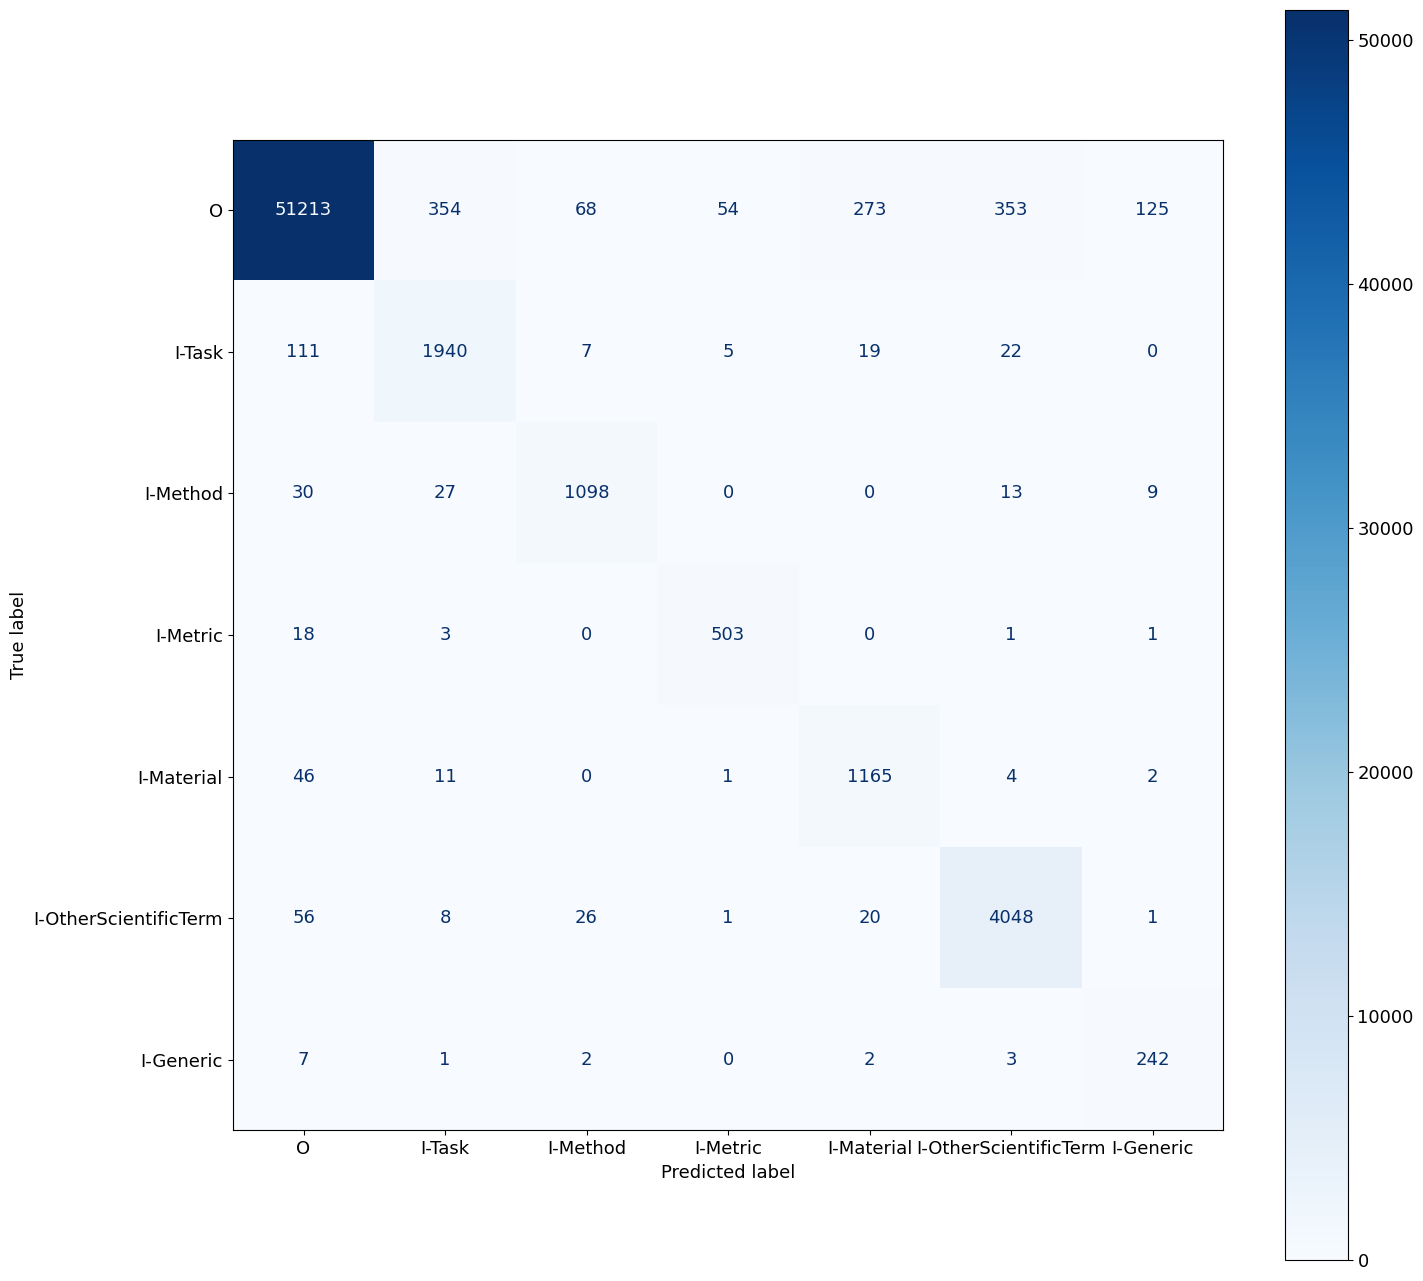

In [58]:
from sklearn.metrics import mean_squared_error, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 13})

labels = ["O", "I-Task", "I-Method", "I-Metric", "I-Material", "I-OtherScientificTerm", "I-Generic"]
cm = confusion_matrix(output_real[0], output_preds[0], labels=labels)
for x in range(len(output_real)-1):
  cm += confusion_matrix(output_real[x+1], output_preds[x+1], labels=labels)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

In [59]:
del cm

In [60]:
len(output_real)

1978

# Test over Text

In [ ]:
def prepare_input(txt):
  inputs = BertTokenizer(txt, return_tensors='pt', padding='max_length', truncation=True, max_length=150).to('cuda')
  return inputs

input_text = ["English is shown to be trans-context-free on the basis of coordinations of the respectively type that involve strictly syntactic cross-serial agreement."]
#input_text = ["The transient analysis of gyro-elastic structured media, composed of periodically placed masses interconnected by elastic rods and attached to gyroscopic spinners, is presented."]
#input_text = ["The results indicated that thermal curing promoted the early strength of mortars, while decreased the late strength of mortars."]
#input_text = ["A wide variety of processes are attested in the literature, and we find different forms of clippings in our data, including mixtures of different clippings, homophone respellings, phonetic respellings in-cluding informal oral forms, initialisms (but no acronyms), and mixtures of clipping together with homo-phone and phonetic respellings."]

input_text = ["The goal is to accurately predict the running time of applications for task scheduling and job migration."]
input_text = ["This paper reports on the development of a cross-domain framework for describing complex design practices."]
input_text = ["Studies of inequality in China typically ignore cost of liv-ing differences between areas."]
input_text = ["The present study was designed to explore the long-term differences be-tween three mouse models for depression."]
input_text = ["Finally, regarding professional competencies, teachers appeared to be largely unprepared to conduct language assessments consistent with the LAR demands."]

#input_text = ["propose a fast and reliable restoration method of virtual resources on OpenStack when physical servers or virtual machines are down."]
#input_text = ["The results from our simulations reveal that the network assisted adaptation clearly outperforms the purely client-based DASH heuristics in some of the metrics, not all of them, particularly, in situations when the achievable throughput is moderately high or the link quality of the mobile clients does not differ from each other substantially."]
#input_text = ["For hard rock drilling in coal mine, the drilling efficiency and service life of polycrystalline diamond compact bit are very low."]
#input_text = ["Capturing changes in foreign reserves and exchange rates through the exchange market pressure, this article investigates whether economic policy uncertainty plays any role in exchange market pressure movements while controlling for the effects of domestic and external factors."]
#input_text = ["This paper presents design of an self contained actuators unit in wide area damping control of power system in stabilizing system response for both nominal system condition and during actuator faults."]

#input_text = ["Ultrasound-based brain stimulation techniques may become a powerful new technique to modulate the human brain in a focal and targeted manner."]
input_text = ["Recent work pre-training Transformers with self-supervised objectives on large text corpora has shown great success when fine-tuned on downstream NLP tasks including text summarization."]

# Tokenize + pad
inputs = prepare_input(input_text)

#inputs
#print(inputs)

In [ ]:
# Pytorch thing (if we aren't training, do this)
ner_model.eval()

# Get predictions
preds = ner_model(**inputs).cpu().detach().numpy()
preds = np.argmax(preds, axis=-1)[0]
pred_labels = [ID2Entity(x) for x in preds]

# Convert token ids to text
tokens = BertTokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Display result
for token, label in zip(tokens, pred_labels):
  if token == '[SEP]':
    break
  if token == '[CLS]':
    continue
  print('{} -> {}'.format(token, label))

recent -> None
work -> None
pre -> None
- -> None
training -> None
transformers -> None
with -> None
self -> None
- -> None
supervised -> None
objectives -> None
on -> None
large -> Material
text -> Material
corpora -> Material
has -> None
shown -> None
great -> None
success -> None
when -> None
fine -> None
- -> None
tuned -> None
on -> None
downstream -> None
nl -> Task
##p -> Task
tasks -> None
including -> None
text -> Task
summar -> Task
##ization -> Task
. -> None


# Model Save and Load

In [ ]:
print("Our model: \n\n", ner_model, '\n')
print("The state dict keys: \n\n", ner_model.state_dict().keys())

Our model: 

 NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
torch.save(ner_model.state_dict(), 'trained_model_dic.pth')

In [ ]:
# download checkpoint file
files.download('trained_model_dic.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls

checkpoint.pth	  model-fold-1.pth  model-fold-4.pth  trained_model_dic.pth
dev.json	  model-fold-2.pth  sample_data       trained_scibert_ner_model
model-fold-0.pth  model-fold-3.pth  test.json	      train.json


Loading the model

In [ ]:
!ls

dev.json  sample_data  test.json  trained_model_dic.pth  train.json


In [ ]:
state_dict = torch.load('trained_model_dic.pth')
print(state_dict.keys())

odict_keys(['sci_embeddings.embeddings.position_ids', 'sci_embeddings.embeddings.word_embeddings.weight', 'sci_embeddings.embeddings.position_embeddings.weight', 'sci_embeddings.embeddings.token_type_embeddings.weight', 'sci_embeddings.embeddings.LayerNorm.weight', 'sci_embeddings.embeddings.LayerNorm.bias', 'sci_embeddings.encoder.layer.0.attention.self.query.weight', 'sci_embeddings.encoder.layer.0.attention.self.query.bias', 'sci_embeddings.encoder.layer.0.attention.self.key.weight', 'sci_embeddings.encoder.layer.0.attention.self.key.bias', 'sci_embeddings.encoder.layer.0.attention.self.value.weight', 'sci_embeddings.encoder.layer.0.attention.self.value.bias', 'sci_embeddings.encoder.layer.0.attention.output.dense.weight', 'sci_embeddings.encoder.layer.0.attention.output.dense.bias', 'sci_embeddings.encoder.layer.0.attention.output.LayerNorm.weight', 'sci_embeddings.encoder.layer.0.attention.output.LayerNorm.bias', 'sci_embeddings.encoder.layer.0.intermediate.dense.weight', 'sci_emb

In [ ]:
ner_model = NerModel(BertEmbModel).to('cuda')
ner_model.load_state_dict(state_dict)

<All keys matched successfully>

# Obtain datasets' weights values (Do not run - fixed values)

In [ ]:
zero = 0
one=0
two=0
three=0
four=0
five=0
six=0
local_set = train
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1

print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

0:  36134 1:  2658 2:  3905 3:  485 4:  1356 5:  3567 6:  1029


In [ ]:
zero = 0
one=0
two=0
three=0
four=0
five=0
six=0
local_set = test
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1

print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

In [ ]:
zero = 0
one=0
two=0
three=0
four=0
five=0
six=0
local_set = val
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1

print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)